In [ ]:
!nvidia-smi

Mon Dec 13 08:49:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install -q kaggle


In [ ]:
from google.colab import files

In [ ]:
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rekibuzzaman","key":"8a0bdf534c511232ddecd27648efd160"}'}

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          17681  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10547  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5203  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3802  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=9be67c0d02264fbb4eb57ed475374c9fa961d8f7aadc27ddabfb9935fd88b98a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:23<00:00, 37.9MB/s]
100% 9.51G/9.51G [03:23<00:00, 50.3MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip aptos2019-blindness-detection.zip -d train

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
def load_data():
    train = pd.read_csv('train/train.csv')
    test = pd.read_csv('train/test.csv')
    
    train_dir = os.path.join('./train/','train_images/')
    test_dir = os.path.join('./train/','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [ ]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train/train_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train/train_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train/train_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train/train_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train/train_images/005b95c28852.png,005b95c28852.png
5,0083ee8054ee,4,./train/train_images/0083ee8054ee.png,0083ee8054ee.png


In [ ]:
df_train_train,df_train_valid = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_valid.shape)

(2929, 4) (733, 4)


In [ ]:
IMG_SIZE  = 512

In [ ]:

def preprocess_image(file):
    input_filepath = os.path.join('./train/','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./train/','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
for im in list(df_train_train.id_code.values):
  print(im)
  preprocess_image(im)


In [ ]:
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="./train/train_images/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="./train/train_images/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                      directory = "./train/test_images/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_test)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
from tensorflow.keras import applications

In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor)
    # base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

366 91


In [ ]:
from tensorflow.keras import optimizers

In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 478s 1s/step - loss: 1.9497 - accuracy: 0.4120 - val_loss: 1.3507 - val_accuracy: 0.4670
Epoch 2/2
366/366 [==============================] - 473s 1s/step - loss: 1.3678 - accuracy: 0.4767 - val_loss: 1.4100 - val_accuracy: 0.4615


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/40
366/366 [==============================] - 508s 1s/step - loss: 0.2707 - accuracy: 0.7269 - val_loss: 3.0489 - val_accuracy: 0.4615 - lr: 1.0000e-04
Epoch 2/40
366/366 [==============================] - 496s 1s/step - loss: 0.2035 - accuracy: 0.7741 - val_loss: 0.3979 - val_accuracy: 0.5577 - lr: 1.0000e-04
Epoch 3/40
366/366 [==============================] - 491s 1s/step - loss: 0.1750 - accuracy: 0.8200 - val_loss: 0.2755 - val_accuracy: 0.7390 - lr: 1.0000e-04
Epoch 4/40
366/366 [==============================] - 495s 1s/step - loss: 0.1641 - accuracy: 0.8268 - val_loss: 0.2269 - val_accuracy: 0.7898 - lr: 1.0000e-04
Epoch 5/40
366/366 [==============================] - 492s 1s/step - loss: 0.1453 - accuracy: 0.8484 - val_loss: 0.3263 - val_accuracy: 0.6332 - lr: 1.0000e-04
Epoch 6/40
366/366 [==============================] - 498s 1s/step - loss: 0.1400 - accuracy: 0.8617 - val_loss: 0.1614 - val_accuracy: 0.8297 - lr: 1.0000e-04
Epoch 7/40
366/366 [====================

In [ ]:
model.save('/content/drive/MyDrive/seminar/project/model/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/seminar/project/model/assets


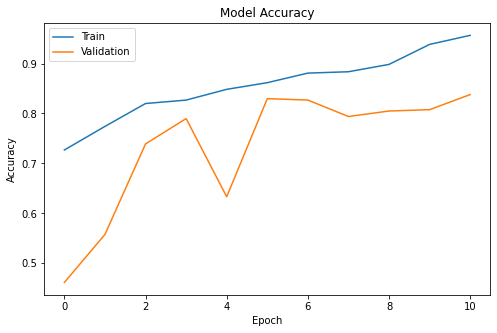

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
from tensorflow.math import confusion_matrix

In [ ]:
predimg = cv2.imread('/content/train/train_images/00b74780d31d.png')
predimg = cv2.resize(predimg, (320,320))
predimg = predimg/255
predimg = predimg.reshape((1,) + predimg.shape)

In [ ]:
predimg.shape

(1, 320, 320, 3)

In [ ]:
result = model.predict(predimg)

In [ ]:
import tensorflow as tf

In [ ]:
tf.nn.softmax(result)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.15596807, 0.15819569, 0.34531492, 0.16052535, 0.17999595]],
      dtype=float32)>

In [ ]:
result

array([[0.00378586, 0.0179674 , 0.7985914 , 0.03258645, 0.147069  ]],
      dtype=float32)

In [ ]:
np.argmax(result)